In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib as mpl
from matplotlib.patches import Patch
import scienceplots
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm
from scipy.spatial.distance import jensenshannon
# import pymc as pm
# import aesara.tensor as at
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# import arviz as az
# import pytensor.tensor as at

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

COLORS = ["#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6",
          "#FF2C00", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000", "#e3e3e3", "#00ffe5", "#ed706b", "#6665f6"]
MARKERS = ["o", "^", "s", "P", "o", "X", "^", "v"]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted"]

mpl.rcParams["hatch.linewidth"] = 0.7
mpl.rcParams.update(mpl.rcParamsDefault)


# Unpaid Pilot Analysis: Preprocess Data

In [2]:
ball_comp = {(2,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.3, 'p_col2_u2':0.7}, 
             (2,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.2, 'p_col2_u2':0.1, 'p_col3_u2':0.7},
             (2,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.2, 'p_col3_u2':0.3, 'p_col4_u2':0.4},
             (3,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.5, 'p_col2_u2':0.5, 'p_col1_u3':0.3, 'p_col2_u3':0.7},
             (3,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7},
             (3,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.2, 'p_col3_u2':0.2, 'p_col4_u2':0.3, 'p_col1_u3':0.1, 'p_col2_u3':0.2, 'p_col3_u3':0.3, 'p_col4_u3':0.4},
             (4,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.6, 'p_col2_u2':0.4, 'p_col1_u3':0.4, 'p_col2_u3':0.6, 'p_col1_u4':0.3, 'p_col2_u4':0.7},
             (4,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7, 'p_col1_u4':0.3, 'p_col2_u4':0.4, 'p_col3_u4':0.3},
             (4,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.4, 'p_col3_u2':0.1, 'p_col4_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.4, 'p_col4_u3':0.3, 'p_col1_u4':0.1, 'p_col2_u4':0.2, 'p_col3_u4':0.3, 'p_col4_u4':0.4}
}

## Read Data

In [3]:
def read_participant_data(filePath, min_pID, max_pID, max_instances):
    participantsWithData = []
    for pID in range(min_pID, max_pID):
        completed = True
        for instance_num in range(1, max_instances+1):
            try:
                with open(filePath + f'p{pID}BU{instance_num}.json') as f:
                    data = json.load(f)
                    df = pd.json_normalize(data)
                    if 'participant_data' not in locals():
                        participant_data = df
                    else:
                        participant_data = pd.concat([participant_data, df], ignore_index=True)
                
            except FileNotFoundError:
                completed = False
                
        if completed:
            participantsWithData.append(pID)

    print(f'Participants with complete data: {participantsWithData}')
    incomplete_data_participants = [pID for pID in participant_data["participantID"].unique() if int(pID) not in participantsWithData]
    print(f'Participants with incomplete data: {incomplete_data_participants}')
    return participant_data, incomplete_data_participants

In [4]:
# Read participant data from json
min_pID = 1
max_pID = 10001
max_instances = 18
filePath = '../Unpaid Pilot/participantData/'

participant_data, incomplete_lis = read_participant_data(filePath, min_pID, max_pID, max_instances)

Participants with complete data: [1003, 1005, 1010, 10000]
Participants with incomplete data: ['1001']


### Eliminate all imcomplete data

In [5]:
participant_data = participant_data[~participant_data['participantID'].isin(incomplete_lis)]

## Disaggregate Posteriors

In [6]:
def disaggregatePosteriors(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_r'] = row['urnPosteriors'][i]
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_r'] = row['colourPosteriors'][j]
            

In [7]:
max_urns = 4
max_colours = 4
urn_names = ['uA', 'uB', 'uC', 'uD']
col_names = ['cB', 'cW', 'cP', 'cG']

disaggregatePosteriors(participant_data, urn_names, col_names)

## Reproduce the number of urns and number of colours

In [8]:
participant_data['urns'] = participant_data['urnPosteriors'].apply(lambda x: len(x))
participant_data['colours'] = participant_data['colourPosteriors'].apply(lambda x: len(x))

## Read Correct Answer from File

Note: Need to change the file in the working directory if the input file is changed for my experiment

In [9]:
def read_correctAnswers():
    with open('obj_posteriors.json') as f:
        correctAnswers = json.load(f)
        return correctAnswers
    
correctAnswers = read_correctAnswers()

## Add Correct Probabilities to the df

In [10]:
def addCorrectAnswers(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_c'] = correctAnswers[row['instanceName']][f'posterior_u{i+1}_draw{row["seqBall"]}'] *100
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_c'] = correctAnswers[row['instanceName']][f'posterior_col{j+1}_draw{row["seqBall"]}'] *100

addCorrectAnswers(participant_data, urn_names, col_names)

## Calculate Step-wise Bayesian Posteriors

### Get the last reported posterior

In [11]:
participant_data['urnPosteriors-1'] = participant_data['urnPosteriors'].shift(1)

In [12]:
def bayesian_Updating_Urns_StepWise(num_urns, num_col, seqBall, ball_draws, prior, ball_comp = dict()):
    '''
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    seqBall: number of sequential ball draws
    ball_draws: a list of ball draw event outcomes. e.g. ['col1','col2']
    prior: a list of the reported posterior from the previous draw e.g.[45.0, 55.0]	
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    output: a rounded (2 decimal points) dictionary of posterior
    '''
    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"
    assert type(ball_comp) == dict, "ball_comp must be a pre-defined dictionary of ball compositions"

    # initialize priors

    if seqBall == 1:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = 1/num_urns
    else:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = prior[urn-1]/100    

    # get ball composition probabilities - Likelihood
    relevant_p = ball_comp[(num_urns,num_col)]

    # Sequential Ball Draws using Bayesian Updating
    evidence_dict = {}
    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += prior_dict[f"prior_u{urn}"] * relevant_p[f"p_col{col}_u{urn}"]

        evidence_dict[f"p_col{col}"] = sum
    # calculate posterior
    posterior_dict = {}
    event =  ball_draws[seqBall-1]
    for urn in range(1, num_urns+1):
        posterior_dict[f"u{urn}"] = (prior_dict[f"prior_u{urn}"] * relevant_p[f"p_{event}_u{urn}"]) / evidence_dict[f"p_{event}"]


    rounded_dict = {key: round(value, 2) for key, value in posterior_dict.items()}    


    return rounded_dict

### Get ball draw events from input

In [13]:
# read JSON input file
filename = 'input.json'
with open(filename) as json_file:
    data = json.load(json_file)

# calculate posteriors for all instances
name_cols = ['B','W','P','G']
data_list = []

for instance in data:
    # key is 'BU1', value is a dictionary of urn info: urnName, prior, composition, balls, chosenUrn, ballDraws
    for key, value in instance.items():
        ball_draws = value['ballDraws']

        # Create a dictionary that maps each color name to "col1", "col2", etc.
        color_mapping = {color: f"col{i+1}" for i, color in enumerate(name_cols)}
        # Map each color in color_list to its corresponding label
        mapped_ball_draws = [color_mapping[color] for color in ball_draws]
        
        # Append to data list
        data_list.append({'instanceName': key, 'ballDrawCol': mapped_ball_draws})

# Create dataframe
ballDrawCol_df = pd.DataFrame(data_list)

participant_data = pd.merge(participant_data, ballDrawCol_df, on='instanceName')


In [14]:
participant_data['urnPosSW'] = participant_data.apply(lambda x: bayesian_Updating_Urns_StepWise(x['urns'], x['colours'], x['seqBall'], x['ballDrawCol'], x['urnPosteriors-1'],ball_comp), axis=1)

### Step-wise Colour Posterior Updating

In [15]:
def ColGuess_StepWise(num_urns, num_col, urn_posteriors=dict(), ball_comp=dict()):
    '''
    Given the urn posteriors and urn composition, using weighted average method to guess the next ball draw colour
    Input: 
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    urn_posteriors: updated urn posteriors dictionary after each ball draw
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    
    Output: a dictionary of the guessed colour
    '''

    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"

    col_posteriors = {}
    # calculate the weighted average for each colour

    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += urn_posteriors[urn-1]/100 * ball_comp[(num_urns,num_col)][f"p_col{col}_u{urn}"]
        
        col_posteriors[f"c{col}"] = sum
    
    rounded_dict = {key: round(value, 2) for key, value in col_posteriors.items()}

    return rounded_dict

In [16]:
participant_data['colPosSW'] = participant_data.apply(lambda x: ColGuess_StepWise(x['urns'], x['colours'], x['urnPosteriors'],ball_comp), axis=1)

### Expand Columns

In [17]:
# Function to expand urnPosSW column into separate columns
def expand_urnPosSW(row):
    urnPosSW = row['urnPosSW']
    row['uA_s'] = urnPosSW.get('u1', np.nan)
    row['uB_s'] = urnPosSW.get('u2', np.nan)
    row['uC_s'] = urnPosSW.get('u3', np.nan)
    row['uD_s'] = urnPosSW.get('u4', np.nan)
    return row

def expand_colPosSW(row):
    urnPosSW = row['colPosSW']
    row['cB_s'] = urnPosSW.get('c1', np.nan)
    row['cW_s'] = urnPosSW.get('c2', np.nan)
    row['cP_s'] = urnPosSW.get('c3', np.nan)
    row['cG_s'] = urnPosSW.get('c4', np.nan)
    return row
# Apply the function to each row in the dataframe
participant_data = participant_data.apply(expand_urnPosSW, axis=1)
participant_data = participant_data.apply(expand_colPosSW, axis=1)

# Drop the original urnPosSW column if no longer needed
participant_data.drop(columns=['urnPosSW','urnPosteriors-1','ballDrawCol','colPosSW'], inplace=True)

# Display the updated dataframe
display(participant_data)

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s
0,1003,BU1,1,"[45.0, 55.0]","[40.0, 60.0]",8.99,11.28,45.00,55.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.48,0.52,NaN,NaN
1,1003,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",7.44,5.94,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.66,0.34,NaN,NaN,0.50,0.50,NaN,NaN
2,1003,BU1,3,"[40.0, 60.0]","[40.0, 60.0]",4.63,12.31,40.00,60.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.46,0.54,NaN,NaN
3,1005,BU1,1,"[30.0, 70.0]","[69.0, 31.0]",8.54,28.07,30.00,70.00,69.00,31.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN
4,1005,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",12.48,8.02,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.50,0.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1010,BU18,2,"[8.0, 13.0, 35.0, 44.0]","[16.0, 16.0, 30.0, 38.0]",78.39,130.13,8.00,13.00,16.00,16.00,30.00,38.00,35.00,44.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.19,0.20,0.30,0.32
212,1010,BU18,3,"[12.0, 8.0, 40.0, 40.0]","[15.0, 15.0, 35.0, 35.0]",34.85,74.05,12.00,8.00,15.00,15.00,35.00,35.00,40.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.05,0.04,0.47,0.44,0.19,0.19,0.31,0.31
213,10000,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 23.0, 27.0, 30.0]",18.20,51.85,10.00,20.00,20.00,23.00,27.00,30.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.10,0.20,0.30,0.40,0.20,0.22,0.28,0.30
214,10000,BU18,2,"[20.0, 20.0, 30.0, 30.0]","[15.0, 15.0, 30.0, 40.0]",16.78,45.74,20.00,20.00,15.00,15.00,30.00,40.00,30.00,30.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.23,0.23,0.27,0.27


## Calculate Absolute Difference between reported answer and correct answer

In [18]:
participant_data['diff_uA'] = abs(participant_data['uA_r'] - participant_data['uA_c'])
participant_data['diff_uB'] = abs(participant_data['uB_r'] - participant_data['uB_c'])
participant_data['diff_uC'] = abs(participant_data['uC_r'] - participant_data['uC_c'])
participant_data['diff_uD'] = abs(participant_data['uD_r'] - participant_data['uD_c'])
participant_data['diff_cB'] = abs(participant_data['cB_r'] - participant_data['cB_c'])
participant_data['diff_cW'] = abs(participant_data['cW_r'] - participant_data['cW_c'])
participant_data['diff_cP'] = abs(participant_data['cP_r'] - participant_data['cP_c'])
participant_data['diff_cG'] = abs(participant_data['cG_r'] - participant_data['cG_c'])

## Calculate JSD Distance

In [19]:
def JSD(row, lis1, lis2):
    vec1 = row[lis1].to_numpy(dtype=float)
    vec2 = row[lis2].to_numpy(dtype=float)
    vec1 = np.nan_to_num(vec1)
    vec2 = np.nan_to_num(vec2)
    return jensenshannon(vec1, vec2, base=2)


participant_data['JSD_U_rc'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_c', 'uB_c', 'uC_c', 'uD_c']), axis=1)
participant_data['JSD_C_rc'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_c', 'cW_c', 'cP_c', 'cG_c']), axis=1)
participant_data['JSD_U_rs'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_s', 'uB_s', 'uC_s', 'uD_s']), axis=1)
participant_data['JSD_C_rs'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_s', 'cW_s', 'cP_s', 'cG_s']), axis=1)


participant_data

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs
0,1003,BU1,1,"[45.0, 55.0]","[40.0, 60.0]",8.99,11.28,45.00,55.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.48,0.52,NaN,NaN,15.00,15.00,NaN,NaN,2.00,2.00,NaN,NaN,0.13,0.02,0.13,0.07
1,1003,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",7.44,5.94,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.66,0.34,NaN,NaN,0.50,0.50,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.14,0.00
2,1003,BU1,3,"[40.0, 60.0]","[40.0, 60.0]",4.63,12.31,40.00,60.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.46,0.54,NaN,NaN,10.00,10.00,NaN,NaN,2.00,2.00,NaN,NaN,0.09,0.02,0.09,0.05
3,1005,BU1,1,"[30.0, 70.0]","[69.0, 31.0]",8.54,28.07,30.00,70.00,69.00,31.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,27.00,27.00,NaN,NaN,0.00,0.23,0.00,0.23
4,1005,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",12.48,8.02,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.50,0.50,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1010,BU18,2,"[8.0, 13.0, 35.0, 44.0]","[16.0, 16.0, 30.0, 38.0]",78.39,130.13,8.00,13.00,16.00,16.00,30.00,38.00,35.00,44.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.19,0.20,0.30,0.32,1.00,6.00,8.00,1.00,2.00,2.00,2.00,6.00,0.10,0.05,0.10,0.07
212,1010,BU18,3,"[12.0, 8.0, 40.0, 40.0]","[15.0, 15.0, 35.0, 35.0]",34.85,74.05,12.00,8.00,15.00,15.00,35.00,35.00,40.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.05,0.04,0.47,0.44,0.19,0.19,0.31,0.31,8.00,6.00,13.00,0.00,2.00,0.00,1.00,2.00,0.19,0.03,0.14,0.07
213,10000,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 23.0, 27.0, 30.0]",18.20,51.85,10.00,20.00,20.00,23.00,27.00,30.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.10,0.20,0.30,0.40,0.20,0.22,0.28,0.30,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.01,0.00,0.01
214,10000,BU18,2,"[20.0, 20.0, 30.0, 30.0]","[15.0, 15.0, 30.0, 40.0]",16.78,45.74,20.00,20.00,15.00,15.00,30.00,40.00,30.00,30.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.23,0.23,0.27,0.27,13.00,13.00,13.00,13.00,3.00,3.00,2.00,8.00,0.25,0.07,0.25,0.15


## Calculate Decision Quality

### Overall Decision Quality

In [20]:
participant_data['DQ_U_o'] = 1 - participant_data['JSD_U_rc'] 
participant_data['DQ_C_o'] = 1 - participant_data['JSD_C_rc']

### Step-wise Decision Quality

In [21]:
participant_data['DQ_U_s'] = 1 - participant_data['JSD_U_rs']
participant_data['DQ_C_s'] = 1 - participant_data['JSD_C_rs']
participant_data

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s
0,1003,BU1,1,"[45.0, 55.0]","[40.0, 60.0]",8.99,11.28,45.00,55.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.48,0.52,NaN,NaN,15.00,15.00,NaN,NaN,2.00,2.00,NaN,NaN,0.13,0.02,0.13,0.07,0.87,0.98,0.87,0.93
1,1003,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",7.44,5.94,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.66,0.34,NaN,NaN,0.50,0.50,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.14,0.00,1.00,1.00,0.86,1.00
2,1003,BU1,3,"[40.0, 60.0]","[40.0, 60.0]",4.63,12.31,40.00,60.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.46,0.54,NaN,NaN,10.00,10.00,NaN,NaN,2.00,2.00,NaN,NaN,0.09,0.02,0.09,0.05,0.91,0.98,0.91,0.95
3,1005,BU1,1,"[30.0, 70.0]","[69.0, 31.0]",8.54,28.07,30.00,70.00,69.00,31.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,27.00,27.00,NaN,NaN,0.00,0.23,0.00,0.23,1.00,0.77,1.00,0.77
4,1005,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",12.48,8.02,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.50,0.50,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1010,BU18,2,"[8.0, 13.0, 35.0, 44.0]","[16.0, 16.0, 30.0, 38.0]",78.39,130.13,8.00,13.00,16.00,16.00,30.00,38.00,35.00,44.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.19,0.20,0.30,0.32,1.00,6.00,8.00,1.00,2.00,2.00,2.00,6.00,0.10,0.05,0.10,0.07,0.90,0.95,0.90,0.93
212,1010,BU18,3,"[12.0, 8.0, 40.0, 40.0]","[15.0, 15.0, 35.0, 35.0]",34.85,74.05,12.00,8.00,15.00,15.00,35.00,35.00,40.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.05,0.04,0.47,0.44,0.19,0.19,0.31,0.31,8.00,6.00,13.00,0.00,2.00,0.00,1.00,2.00,0.19,0.03,0.14,0.07,0.81,0.97,0.86,0.93
213,10000,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 23.0, 27.0, 30.0]",18.20,51.85,10.00,20.00,20.00,23.00,27.00,30.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.10,0.20,0.30,0.40,0.20,0.22,0.28,0.30,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.01,0.00,0.01,1.00,0.99,1.00,0.99
214,10000,BU18,2,"[20.0, 20.0, 30.0, 30.0]","[15.0, 15.0, 30.0, 40.0]",16.78,45.74,20.00,20.00,15.00,15.00,30.00,40.00,30.00,30.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.23,0.23,0.27,0.27,13.00,13.00,13.00,13.00,3.00,3.00,2.00,8.00,0.25,0.07,0.25,0.15,0.75,0.93,0.75,0.85


## Calculate Computational Complexity

In [22]:
def calculate_StepWise_complexity():
    '''
    total complexity treats MD and AS equally
    MD complexity quantify MD only and ignore AS
    weighted complexity count MD as 2 Basic operations and AS as 1 Basic operation
    '''
    for idx, row in participant_data.iterrows():
        num_urns = len(row['urnPosteriors'])
        num_colours = len(row['colourPosteriors'])

        if row['seqBall'] == 1:
            urn_complexity_total = min(2 * num_urns, 2 * (num_urns - 1) + (num_urns - 1) )
            urn_complexity_MD = 2 * (num_urns - 1)
            urn_complexity_weighted = min(4 * num_urns, 4 * (num_urns - 1) + (num_urns - 1) )
        else:
            urn_complexity_total = min(5*num_urns - 4, 4*num_urns - 1)
            urn_complexity_MD = 3*num_urns - 2
            urn_complexity_weighted = min(8*num_urns - 6, 7*num_urns - 1)
        
        col_complexity_total = min(num_colours * (num_urns + (num_urns - 1)), (num_colours-1)* (num_urns + (num_urns - 1)) + (num_colours-1))
        col_complexity_MD =  (num_colours-1) * num_urns
        col_complexity_weighted =  min(num_colours * (2*num_urns + (num_urns - 1)), (num_colours-1)* (2*num_urns + (num_urns - 1)) + (num_colours-1))

        participant_data.at[idx, 'EWCC_u'] = urn_complexity_total
        participant_data.at[idx, 'MDCC_u'] = urn_complexity_MD
        participant_data.at[idx, 'CC_u'] = urn_complexity_weighted
        participant_data.at[idx, 'EWCC_c'] = col_complexity_total
        participant_data.at[idx, 'MDCC_c'] = col_complexity_MD
        participant_data.at[idx, 'CC_c'] = col_complexity_weighted




calculate_StepWise_complexity()

### Calculate Accumulated Computational Complexity

In [23]:
participant_data['EWCC_u_-1'] = participant_data['EWCC_u'].shift(1)
participant_data['EWCC_u_-2'] = participant_data['EWCC_u'].shift(2)
participant_data['MDCC_u_-1'] = participant_data['MDCC_u'].shift(1)
participant_data['MDCC_u_-2'] = participant_data['MDCC_u'].shift(2)
participant_data['CC_u_-1'] = participant_data['CC_u'].shift(1)
participant_data['CC_u_-2'] = participant_data['CC_u'].shift(2)
participant_data['EWCC_c_-1'] = participant_data['EWCC_c'].shift(1)
participant_data['EWCC_c_-2'] = participant_data['EWCC_c'].shift(2)
participant_data['MDCC_c_-1'] = participant_data['MDCC_c'].shift(1)
participant_data['MDCC_c_-2'] = participant_data['MDCC_c'].shift(2)
participant_data['CC_c_-1'] = participant_data['CC_c'].shift(1)
participant_data['CC_c_-2'] = participant_data['CC_c'].shift(2)

In [24]:
def calculate_ACC(row,CC_col_name):
    '''
    Calculate the ACC for each participant
    '''
    if row['seqBall'] == 1:
        return row[CC_col_name]
    elif row['seqBall'] == 2:
        return row[CC_col_name] + row[f'{CC_col_name}_-1']
    else:
        return row[CC_col_name] + row[f'{CC_col_name}_-1'] + row[f'{CC_col_name}_-2']

participant_data['ACC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_u'), axis=1)
participant_data['ACC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_c'), axis=1)
participant_data['AEWCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_u'), axis=1)
participant_data['AEWCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_c'), axis=1)
participant_data['AMDCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_u'), axis=1)
participant_data['AMDCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_c'), axis=1)

participant_data

,participantID,instanceName,seqBall,urnPosteriors,colourPosteriors,responseTimeUrn,responseTimeColour,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,EWCC_u,MDCC_u,CC_u,EWCC_c,MDCC_c,CC_c,EWCC_u_-1,EWCC_u_-2,MDCC_u_-1,MDCC_u_-2,CC_u_-1,CC_u_-2,EWCC_c_-1,EWCC_c_-2,MDCC_c_-1,MDCC_c_-2,CC_c_-1,CC_c_-2,ACC_u,ACC_c,AEWCC_u,AEWCC_c,AMDCC_u,AMDCC_c
0,1003,BU1,1,"[45.0, 55.0]","[40.0, 60.0]",8.99,11.28,45.00,55.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.48,0.52,NaN,NaN,15.00,15.00,NaN,NaN,2.00,2.00,NaN,NaN,0.13,0.02,0.13,0.07,0.87,0.98,0.87,0.93,3.00,2.00,5.00,4.00,2.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,6.00,3.00,4.00,2.00,2.00
1,1003,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",7.44,5.94,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.66,0.34,NaN,NaN,0.50,0.50,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.14,0.00,1.00,1.00,0.86,1.00,6.00,4.00,10.00,4.00,2.00,6.00,3.00,NaN,2.00,NaN,5.00,NaN,4.00,NaN,2.00,NaN,6.00,NaN,15.00,12.00,9.00,8.00,6.00,4.00
2,1003,BU1,3,"[40.0, 60.0]","[40.0, 60.0]",4.63,12.31,40.00,60.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.46,0.54,NaN,NaN,10.00,10.00,NaN,NaN,2.00,2.00,NaN,NaN,0.09,0.02,0.09,0.05,0.91,0.98,0.91,0.95,6.00,4.00,10.00,4.00,2.00,6.00,6.00,3.00,4.00,2.00,10.00,5.00,4.00,4.00,2.00,2.00,6.00,6.00,25.00,18.00,15.00,12.00,10.00,6.00
3,1005,BU1,1,"[30.0, 70.0]","[69.0, 31.0]",8.54,28.07,30.00,70.00,69.00,31.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,0.30,0.70,NaN,NaN,0.42,0.58,NaN,NaN,0.00,0.00,NaN,NaN,27.00,27.00,NaN,NaN,0.00,0.23,0.00,0.23,1.00,0.77,1.00,0.77,3.00,2.00,5.00,4.00,2.00,6.00,6.00,6.00,4.00,4.00,10.00,10.00,4.00,4.00,2.00,2.00,6.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00
4,1005,BU1,2,"[50.0, 50.0]","[50.0, 50.0]",12.48,8.02,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,0.50,0.50,NaN,NaN,0.50,0.50,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,6.00,4.00,10.00,4.00,2.00,6.00,3.00,6.00,2.00,4.00,5.00,10.00,4.00,4.00,2.00,2.00,6.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1010,BU18,2,"[8.0, 13.0, 35.0, 44.0]","[16.0, 16.0, 30.0, 38.0]",78.39,130.13,8.00,13.00,16.00,16.00,30.00,38.00,35.00,44.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,0.07,0.07,0.43,0.43,0.19,0.20,0.30,0.32,1.00,6.00,8.00,1.00,2.00,2.00,2.00,6.00,0.10,0.05,0.10,0.07,0.90,0.95,0.90,0.93,15.00,10.00,26.00,24.00,12.00,36.00,8.00,15.00,6.00,10.00,15.00,26.00,24.00,24.00,12.00,12.00,36.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00
212,1010,BU18,3,"[12.0, 8.0, 40.0, 40.0]","[15.0, 15.0, 35.0, 35.0]",34.85,74.05,12.00,8.00,15.00,15.00,35.00,35.00,40.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,0.05,0.04,0.47,0.44,0.19,0.19,0.31,0.31,8.00,6.00,13.00,0.00,2.00,0.00,1.00,2.00,0.19,0.03,0.14,0.07,0.81,0.97,0.86,0.93,15.00,10.00,26.00,24.00,12.00,36.00,15.00,8.00,10.00,6.00,26.00,15.00,24.00,24.00,12.00,12.00,36.00,36.00,67.00,108.00,38.00,72.00,26.00,36.00
213,10000,BU18,1,"[10.0, 20.0, 30.0, 40.0]","[20.0, 23.0, 27.0, 30.0]",18.20,51.85,10.00,20.00,20.00,23.00,27.00,30.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,0.10,0.20,0.30,0.40,0.20,0.22,0.28,0.30,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.01,0.00,0.01,1.00,0.99,1.00,0.99,8.00,6.00,15.00,24.00,12.00,36.00,15.00,15.00,10.00,10.00,26.00,26.00,24.00,24.00,12.00,12.00,36.00,36.00,15

### Remove BU prefix in the instanceName column

In [25]:
participant_data['instanceName'] = participant_data['instanceName'].str.replace('BU', '').astype(int)

### Convert step-wise Bayesian factor into percentage point

In [26]:
def prob_to_percentagePoint(row):
    row['uA_s'] = row['uA_s'] * 100
    row['uB_s'] = row['uB_s'] * 100
    row['uC_s'] = row['uC_s'] * 100
    row['uD_s'] = row['uD_s'] * 100
    row['cB_s'] = row['cB_s'] * 100
    row['cW_s'] = row['cW_s'] * 100
    row['cP_s'] = row['cP_s'] * 100
    row['cG_s'] = row['cG_s'] * 100
    return row

participant_data = participant_data.apply(prob_to_percentagePoint, axis=1)

### Delete Redundent Data

In [27]:
participant_data.drop(columns=['urnPosteriors', 'colourPosteriors', 'EWCC_u_-1', 'EWCC_u_-2', 'MDCC_u_-1', 'MDCC_u_-2', 'CC_u_-1', 'CC_u_-2', 'EWCC_c_-1', 'EWCC_c_-2', 'MDCC_c_-1', 'MDCC_c_-2', 'CC_c_-1', 'CC_c_-2'], inplace=True)

In [28]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r',
       'uC_r', 'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c',
       'cP_c', 'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s',
       'cW_s', 'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD',
       'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc',
       'JSD_U_rs', 'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s',
       'EWCC_u', 'MDCC_u', 'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u',
       'ACC_c', 'AEWCC_u', 'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [29]:
display(participant_data)
participant_data.to_csv('participant_data.csv', index=False)

,participantID,instanceName,seqBall,responseTimeUrn,responseTimeColour,uA_r,uB_r,cB_r,cW_r,cP_r,cG_r,uC_r,uD_r,urns,colours,uA_c,uB_c,cB_c,cW_c,cP_c,cG_c,uC_c,uD_c,uA_s,uB_s,uC_s,uD_s,cB_s,cW_s,cP_s,cG_s,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,JSD_U_rc,JSD_C_rc,JSD_U_rs,JSD_C_rs,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,EWCC_u,MDCC_u,CC_u,EWCC_c,MDCC_c,CC_c,ACC_u,ACC_c,AEWCC_u,AEWCC_c,AMDCC_u,AMDCC_c
0,1003,1,1,8.99,11.28,45.00,55.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,48.00,52.00,NaN,NaN,15.00,15.00,NaN,NaN,2.00,2.00,NaN,NaN,0.13,0.02,0.13,0.07,0.87,0.98,0.87,0.93,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00
1,1003,1,2,7.44,5.94,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,66.00,34.00,NaN,NaN,50.00,50.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.14,0.00,1.00,1.00,0.86,1.00,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00
2,1003,1,3,4.63,12.31,40.00,60.00,40.00,60.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,46.00,54.00,NaN,NaN,10.00,10.00,NaN,NaN,2.00,2.00,NaN,NaN,0.09,0.02,0.09,0.05,0.91,0.98,0.91,0.95,6.00,4.00,10.00,4.00,2.00,6.00,25.00,18.00,15.00,12.00,10.00,6.00
3,1005,1,1,8.54,28.07,30.00,70.00,69.00,31.00,NaN,NaN,NaN,NaN,2,2,30.00,70.00,42.00,58.00,NaN,NaN,NaN,NaN,30.00,70.00,NaN,NaN,42.00,58.00,NaN,NaN,0.00,0.00,NaN,NaN,27.00,27.00,NaN,NaN,0.00,0.23,0.00,0.23,1.00,0.77,1.00,0.77,3.00,2.00,5.00,4.00,2.00,6.00,5.00,6.00,3.00,4.00,2.00,2.00
4,1005,1,2,12.48,8.02,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,2,2,50.00,50.00,50.00,50.00,NaN,NaN,NaN,NaN,50.00,50.00,NaN,NaN,50.00,50.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,6.00,4.00,10.00,4.00,2.00,6.00,15.00,12.00,9.00,8.00,6.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1010,18,2,78.39,130.13,8.00,13.00,16.00,16.00,30.00,38.00,35.00,44.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,7.00,7.00,43.00,43.00,19.00,20.00,30.00,32.00,1.00,6.00,8.00,1.00,2.00,2.00,2.00,6.00,0.10,0.05,0.10,0.07,0.90,0.95,0.90,0.93,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00
212,1010,18,3,34.85,74.05,12.00,8.00,15.00,15.00,35.00,35.00,40.00,40.00,4,4,4.00,2.00,17.00,15.00,34.00,33.00,53.00,40.00,5.00,4.00,47.00,44.00,19.00,19.00,31.00,31.00,8.00,6.00,13.00,0.00,2.00,0.00,1.00,2.00,0.19,0.03,0.14,0.07,0.81,0.97,0.86,0.93,15.00,10.00,26.00,24.00,12.00,36.00,67.00,108.00,38.00,72.00,26.00,36.00
213,10000,18,1,18.20,51.85,10.00,20.00,20.00,23.00,27.00,30.00,30.00,40.00,4,4,10.00,20.00,20.00,22.00,28.00,30.00,30.00,40.00,10.00,20.00,30.00,40.00,20.00,22.00,28.00,30.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.01,0.00,0.01,1.00,0.99,1.00,0.99,8.00,6.00,15.00,24.00,12.00,36.00,15.00,36.00,8.00,24.00,6.00,12.00
214,10000,18,2,16.78,45.74,20.00,20.00,15.00,15.00,30.00,40.00,30.00,30.00,4,4,7.00,7.00,18.00,18.00,32.00,32.00,43.00,43.00,7.00,7.00,43.00,43.00,23.00,23.00,27.00,27.00,13.00,13.00,13.00,13.00,3.00,3.00,2.00,8.00,0.25,0.07,0.25,0.15,0.75,0.93,0.75,0.85,15.00,10.00,26.00,24.00,12.00,36.00,41.00,72.00,23.00,48.00,16.00,24.00


# Balance the Observations for each Complexity

Create dataframe for my experimental design parameters per pre-registration requirement

In [30]:
# 12 Instances: each have 3 ball draws so 36 rows per participant
selected_col = ['CC_u', 'CC_c']
complexity_df = participant_data.groupby(['instanceName', 'seqBall'])[selected_col].mean().reset_index()


In [31]:
instance_info_df = pd.read_csv('Instance_level_design.csv')

In [32]:
design_df = pd.merge(complexity_df, instance_info_df, left_on='instanceName', right_on='Instance', how='left').drop(columns=['Instance'])
design_df

,instanceName,seqBall,CC_u,CC_c,# Urns (k_i),# Colours (c_i),#Ball Draws (n_i),"Composition_i,j"
0,1,1,5.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
1,1,2,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
2,1,3,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
3,2,1,5.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
4,2,2,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
5,2,3,10.00,6.00,2,2,3,"[['7B', '3W'], ['3B', '7W']]"
6,3,1,5.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
7,3,2,10.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
8,3,3,10.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"
9,4,1,5.00,12.00,2,3,3,"[['7B', '2W', '1P'], ['2B', '1W', '7P']]"


In [33]:
# Current Design data frequency per complexity level
complexity_cols = [ 'CC_u', 'CC_c']
for col in complexity_cols:
    print(design_df[col].value_counts().sort_index())

CC_u
5.00      6
10.00    18
15.00     6
18.00    12
26.00    12
Name: count, dtype: int64
CC_c
6.00      6
9.00      6
12.00    12
18.00    12
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64


In [34]:
design_df.groupby(['instanceName','seqBall'])[complexity_cols].mean()

CC_u  CC_c
instanceName seqBall            
1            1        5.00  6.00
             2       10.00  6.00
             3       10.00  6.00
2            1        5.00  6.00
             2       10.00  6.00
             3       10.00  6.00
3            1        5.00 12.00
             2       10.00 12.00
             3       10.00 12.00
4            1        5.00 12.00
             2       10.00 12.00
             3       10.00 12.00
5            1        5.00 18.00
             2       10.00 18.00
             3       10.00 18.00
6            1        5.00 18.00
             2       10.00 18.00
             3       10.00 18.00
7            1       10.00  9.00
             2       18.00  9.00
             3       18.00  9.00
8            1       10.00  9.00
             2       18.00  9.00
             3       18.00  9.00
9            1       10.00 18.00
             2       18.00 18.00
             3       18.00 18.00
10           1       10.00 18.00
             2       18.00 18.00
             3       18.00 18.00
11           1       10.00 27.00
             2       18.00 27.00
             3       18.00 27.00
12           1       10.00 27.00
             2       18.00 27.00
             3       18.00 27.00
13           1       15.00 12.00
             2       26.00 12.00
             3       26.00 12.00
14           1       15.00 12.00
             2       26.00 12.00
             3       26.00 12.00
15           1       15.00 24.00
             2       26.00 24.00
             3       26.00 24.00
16           1       15.00 24.00
             2       26.00 24.00
             3       26.00 24.00
17           1       15.00 36.00
             2       26.00 36.00
             3       26.00 36.00
18           1       15.00 36.00
             2       26.00 36.00
             3       26.00 36.00

In [35]:
# drop 1 instance
drop_lis = [1,3,5,7,9,11,13,15,17]
for i in drop_lis:
    print(f'Dropping instance {i}')
    temp_df = design_df[~design_df['instanceName'].isin([i])]
    for col in complexity_cols:
        print(temp_df[col].value_counts().sort_index())

Dropping instance 1
CC_u
5.00      5
10.00    16
15.00     6
18.00    12
26.00    12
Name: count, dtype: int64
CC_c
6.00      3
9.00      6
12.00    12
18.00    12
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64
Dropping instance 3
CC_u
5.00      5
10.00    16
15.00     6
18.00    12
26.00    12
Name: count, dtype: int64
CC_c
6.00      6
9.00      6
12.00     9
18.00    12
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64
Dropping instance 5
CC_u
5.00      5
10.00    16
15.00     6
18.00    12
26.00    12
Name: count, dtype: int64
CC_c
6.00      6
9.00      6
12.00    12
18.00     9
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64
Dropping instance 7
CC_u
5.00      6
10.00    17
15.00     6
18.00    10
26.00    12
Name: count, dtype: int64
CC_c
6.00      6
9.00      3
12.00    12
18.00    12
24.00     6
27.00     6
36.00     6
Name: count, dtype: int64
Dropping instance 9
CC_u
5.00      6
10.00    17
15.00     6
18.00    10
26.00    12
Name: count

In [36]:
# Let drop several instance 
test_df = design_df[~design_df['instanceName'].isin([4,6,8,10,12,16])]
for col in complexity_cols:
    print(test_df[col].value_counts().sort_index())

CC_u
5.00      4
10.00    11
15.00     5
18.00     6
26.00    10
Name: count, dtype: int64
CC_c
6.00     6
9.00     3
12.00    9
18.00    6
24.00    3
27.00    3
36.00    6
Name: count, dtype: int64


In [37]:
# test_df.drop(columns=['instanceName'], inplace=True)
test_df.to_csv('design_df.csv', index=False)

# Data Analysis

## Aggregate Level Analysis

### Experiment Payment

In [38]:
def random_select_rounds(participant_data, num_rounds):
    '''
    Randomly select num_rounds from each participant
    '''
    selected_rounds = participant_data.groupby('participantID').apply(lambda x: x.sample(n=num_rounds)).reset_index(drop=True)
    columns_needed = ['participantID', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']
    selected_rounds = selected_rounds[columns_needed]
    return selected_rounds

def random_select_responseDifferences(selected_rounds, num_selection):
    '''
    Randomly select num_selection from selected rounds for each participant
    '''
    candidate_columns = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']

    for idx, row in selected_rounds.iterrows():
        selected_column = np.random.choice(candidate_columns, num_selection)
        selected_diff = row[selected_column[0]]
        # make sure the selected diff is not NAN
        while np.isnan(selected_diff):
            selected_column = np.random.choice(candidate_columns, num_selection)
            selected_diff = row[selected_column[0]]

        selected_rounds.at[idx, 'selected_diff'] = selected_diff
    
def calculate_bonus(selected_rounds, bonusMultiplier):
    
    for idx, row in selected_rounds.iterrows():
        bonus = max(0, 10 - bonusMultiplier * row['selected_diff'])
        selected_rounds.at[idx, 'bonus'] = bonus
    
def calculate_payment(selected_rounds, showUpFee):
    payment = selected_rounds.groupby('participantID')['bonus'].sum() + showUpFee
    return payment
    

`Individual Payments In case people are interested`

In [39]:
num_rounds = 4
num_selection = 1
showUpFee = 10
bonusMultiplier = 1
selected_rounds = random_select_rounds(participant_data, num_rounds)
random_select_responseDifferences(selected_rounds, num_selection)
calculate_bonus(selected_rounds, bonusMultiplier)
calculate_payment(selected_rounds, showUpFee)


participantID
10000   24.00
1003    27.00
1005    31.00
1010    42.00
Name: bonus, dtype: float64

#### Payment Simulation: simulate the random bonus draw 1000 times and report the average payment to participants

In [40]:
sim_num = 1000
payment_lis = []
for i in range(sim_num):
    selected_rounds = random_select_rounds(participant_data, num_rounds)
    random_select_responseDifferences(selected_rounds, num_selection)
    calculate_bonus(selected_rounds, bonusMultiplier)
    # average payment across individuals for each experiment iteration
    payment = calculate_payment(selected_rounds, showUpFee)
    avg_payment = payment.mean()
    payment_lis.append(avg_payment)

print(f'Average payment after 10000 simulations: {np.mean(payment_lis)}')


Average payment after 10000 simulations: 30.692


### Summary Statistics

In [41]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r',
       'uC_r', 'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c',
       'cP_c', 'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s',
       'cW_s', 'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD',
       'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc',
       'JSD_U_rs', 'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s',
       'EWCC_u', 'MDCC_u', 'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u',
       'ACC_c', 'AEWCC_u', 'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [42]:
columnOfInterest = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 
                    'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'responseTimeUrn', 'responseTimeColour']
display(participant_data[columnOfInterest].describe())

,diff_uA,diff_uB,diff_uC,diff_uD,diff_cB,diff_cW,diff_cP,diff_cG,DQ_U_o,DQ_C_o,DQ_U_s,DQ_C_s,responseTimeUrn,responseTimeColour
count,216.00,216.00,144.00,72.00,216.00,216.00,144.00,72.00,216.00,216.00,216.00,216.00,216.00,216.00
mean,9.25,8.48,9.38,6.40,4.84,5.00,5.51,4.44,0.86,0.93,0.88,0.91,32.50,33.74
std,11.12,12.29,11.59,8.02,4.66,6.45,7.82,3.81,0.13,0.07,0.11,0.08,30.71,29.95
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.54,0.14,0.54,4.47,5.50
25%,1.00,0.75,2.00,1.00,1.00,1.00,1.00,1.00,0.80,0.90,0.83,0.88,14.65,15.34
50%,6.00,5.00,6.50,4.00,3.00,3.00,3.00,3.50,0.88,0.94,0.90,0.92,23.16,25.31
75%,13.00,12.00,13.00,9.25,8.00,7.00,6.25,6.25,0.96,0.98,0.95,0.97,39.23,40.68
max,85.00,92.00,85.00,44.00,27.00,48.00,50.00,17.00,1.00,1.00,1.00,1.00,256.00,281.43


## Disaggregate according to Each Ball Draw in Each Instance (Average the Performance of each individual)

In [43]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r',
       'uC_r', 'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c',
       'cP_c', 'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s',
       'cW_s', 'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD',
       'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc',
       'JSD_U_rs', 'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s',
       'EWCC_u', 'MDCC_u', 'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u',
       'ACC_c', 'AEWCC_u', 'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [44]:
ins_seq_grouped_mean = participant_data.groupby(['instanceName','seqBall']).mean()
urnColumns = ['DQ_U_o', 'responseTimeUrn',
                    'CC_u'] 


ins_seq_grouped_mean_urn = ins_seq_grouped_mean[urnColumns]
ins_seq_grouped_mean_urn

DQ_U_o  responseTimeUrn  CC_u
instanceName seqBall                               
1            1          0.97            11.39  5.00
             2          1.00            17.06 10.00
             3          0.81            14.70 10.00
2            1          1.00            11.58  5.00
             2          0.93            27.04 10.00
             3          0.88            24.58 10.00
3            1          0.97            16.24  5.00
             2          0.75            16.61 10.00
             3          0.71            14.74 10.00
4            1          0.95            34.63  5.00
             2          0.86            17.93 10.00
             3          0.81            10.20 10.00
5            1          0.89            34.11  5.00
             2          0.72            33.27 10.00
             3          0.68            10.98 10.00
6            1          0.95            18.25  5.00
             2          0.85            20.18 10.00
             3          0.86            13.04 10.00
7            1          0.91            50.57 10.00
             2          0.81            35.37 18.00
             3          0.87            28.10 18.00
8            1          0.96            48.02 10.00
             2          0.89            24.56 18.00
             3          0.91            26.43 18.00
9            1          0.96            17.71 10.00
             2          0.79            23.07 18.00
             3          0.79            28.67 18.00
10           1          0.91            18.66 10.00
             2          0.72            23.56 18.00
             3          0.54            23.49 18.00
11           1          0.98            47.23 10.00
             2          0.84            37.45 18.00
             3          0.80            39.65 18.00
12           1          0.91            32.54 10.00
             2          0.82            14.99 18.00
             3          0.80            23.86 18.00
13           1          0.97            23.64 15.00
             2          0.93            40.53 26.00
             3          0.91            35.06 26.00
14           1          0.96            24.47 15.00
             2          0.92            54.69 26.00
             3          0.97            43.34 26.00
15           1          0.82            92.05 15.00
             2          0.76            57.32 26.00
             3          0.87            40.76 26.00
16           1          0.85           127.26 15.00
             2          0.83            33.10 26.00
             3          0.64            70.15 26.00
17           1          0.94            41.08 15.00
             2          0.88            38.49 26.00
             3          0.84            41.44 26.00
18           1          0.97            24.01 15.00
             2          0.81            49.63 26.00
             3          0.79            27.54 26.00

### Counting how many observations per complexity level

In [45]:
ins_seq_grouped_mean_urn['CC_u'].value_counts()

CC_u
10.00    18
18.00    12
26.00    12
5.00      6
15.00     6
Name: count, dtype: int64

In [46]:
def threeAttributes_bar(df, lengend_var, y_name, y_label, x_name, x_label, out):
    '''
    Input:
    df is the dataframe you want to input. Could introduce the fourth condition by inputing sub-df
    legend_var is the variable name you want to use in the legend, for different bars under same x
    y_name is the name of the variable on the y-axis
    x_name is the name of the variable on the x-axis
    out is the file name including suffix
    '''
    # Aggregate the data to handle duplicates, calculating mean and standard error
    df_aggregated = df.groupby([lengend_var, x_name]).agg({y_name: ['mean', 'sem']}).reset_index()
    df_aggregated.columns = [x_name, lengend_var, 'mean', 'sem']  # Flatten the MultiIndex
    
    # Pivot the DataFrame for mean and sem
    pivot_df_mean = df_aggregated.pivot(index=lengend_var, columns=x_name, values='mean')
    pivot_df_sem = df_aggregated.pivot(index=lengend_var, columns=x_name, values='sem')

    # Number of bars per group
    num_bars = len(pivot_df_mean.columns)
    # Number of groups
    num_groups = len(pivot_df_mean.index)

    # Set width of bars
    bar_width = 0.2
    # Set position of bar on X axis
    r = np.arange(num_groups)

    with plt.style.context("science"):
        # Plotting the bar graph
        fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        # Create bars with error bars
        for i, condition in enumerate(pivot_df_mean.columns):
            ax.bar(
                r + i * bar_width, 
                pivot_df_mean[condition], 
                yerr=pivot_df_sem[condition], 
                width=bar_width, 
                color=COLORS[i % len(COLORS)], 
                label=condition, 
                alpha=0.7, 
                capsize=5
            )

        # Add xticks on the middle of the group bars
        plt.xlabel(x_label, fontweight='bold')
        plt.ylabel(y_label, fontweight='bold')
        plt.xticks([r + bar_width * (num_bars / 2 - 0.5) for r in range(num_groups)], pivot_df_mean.index)

        # Create legend
        plt.legend()

        # Show or save the plot
        if out:
            plt.savefig(f"images/{out}")      
        plt.show()


def twoAttributes_bar(df, y_name, y_label, x_name, x_label,out=False):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name) == str, "y_name is the name of your y column"

    grouped_df =  df.groupby([x_name])
    x =grouped_df.groups.keys()
    grouped_y =grouped_df[y_name]
    y_mean = grouped_y.mean()#.reindex(["Low", "Medium", "High"])
    y_se =  grouped_y.sem()#['attractiveness'].reindex(["Low", "Medium", "High"])


    #cat_name = ['Low', 'Medium', 'High']
    bar_width = 0.3
    bar_positions_group1 = range(len(y_mean.index))
    bar_positions_group2 = [pos + bar_width for pos in bar_positions_group1]

    with plt.style.context("science"):

        fig, axes = plt.subplots( dpi=100, nrows= 1, ncols= 1, figsize=(12, 6))

        axes.bar(x, y_mean, yerr=y_se, capsize=5,
                    width=bar_width, color= COLORS[5], alpha=0.7, label= y_label)


        axes.set_ylabel(y_label)
        axes.set_xlabel(x_label)
        # axes.set_ylim(0,1)
        #axes.set_title(f'Average {x_label} Comparison between {label_1} and {label_2}')
        # Hiding x-axis label and ticks
        # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.legend()
        if out:
            plt.savefig(f"images/{out}")      
        plt.show()

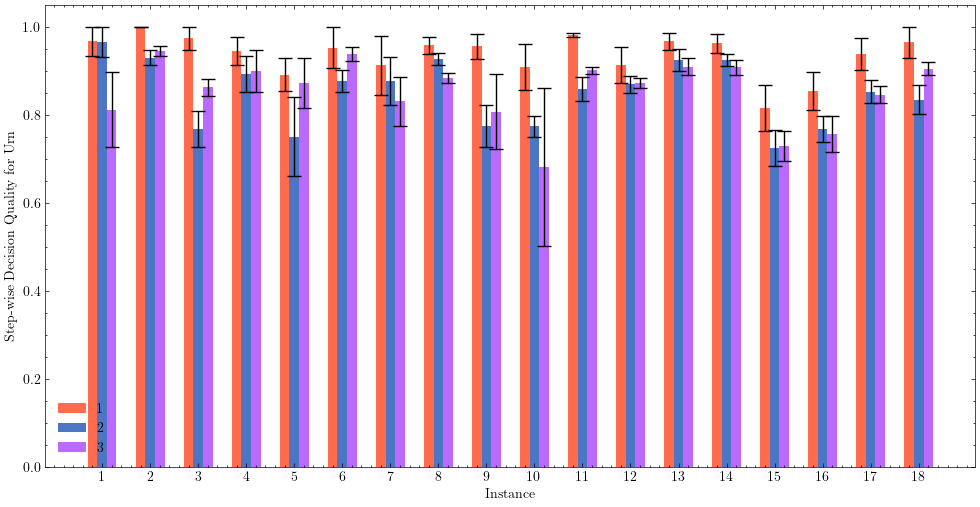

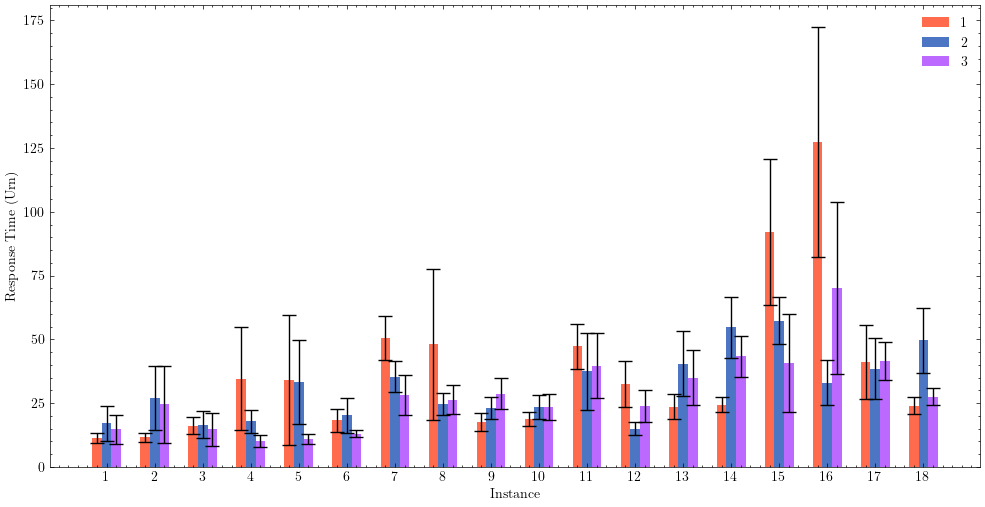

In [47]:
threeAttributes_bar(df=participant_data, lengend_var='seqBall', y_name='DQ_U_s', y_label='Step-wise Decision Quality for Urn', x_name='instanceName', x_label='Instance', out=False)
threeAttributes_bar(df=participant_data, lengend_var='seqBall', y_name='responseTimeUrn', y_label='Response Time (Urn)', x_name='instanceName', x_label='Instance', out=False)

## Disaggregate According to Complexity

### Computational Complexity of each Instance

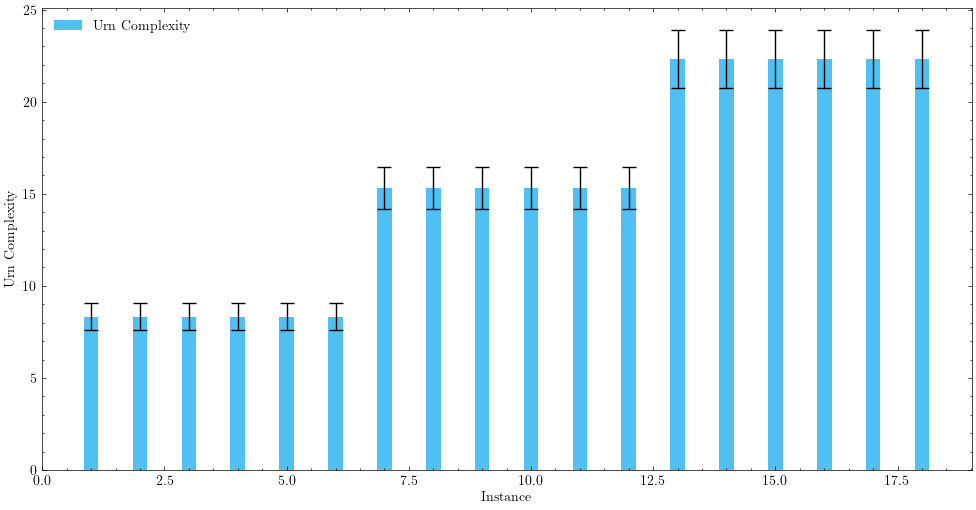

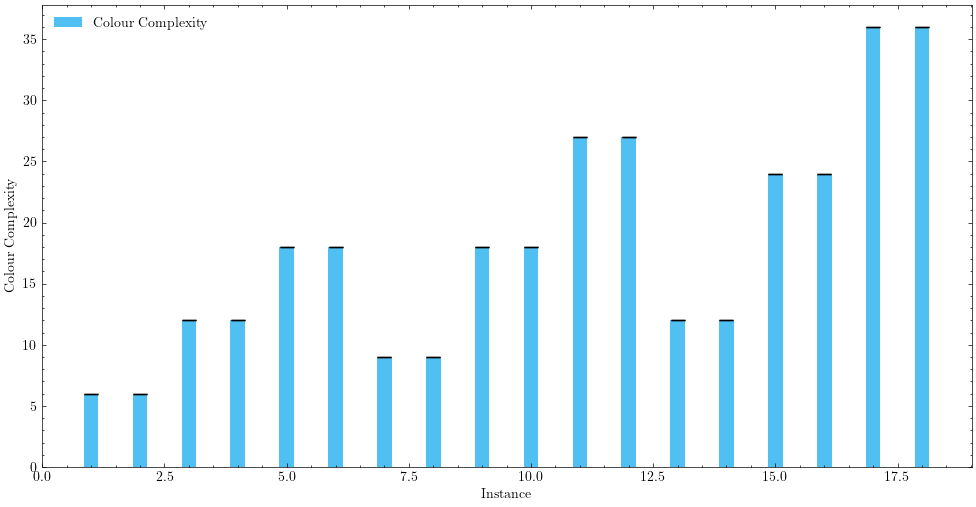

In [48]:
twoAttributes_bar(participant_data, y_name='CC_u', y_label='Urn Complexity ', x_name='instanceName', x_label='Instance', out=False)
twoAttributes_bar(participant_data, y_name='CC_c', y_label='Colour Complexity ', x_name='instanceName', x_label='Instance', out=False)

### Decision Quality Vs Complexity

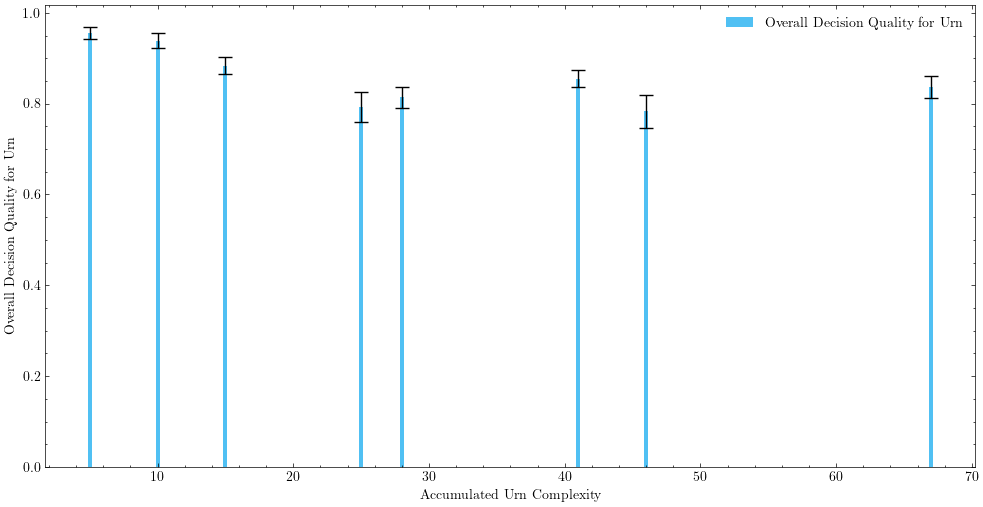

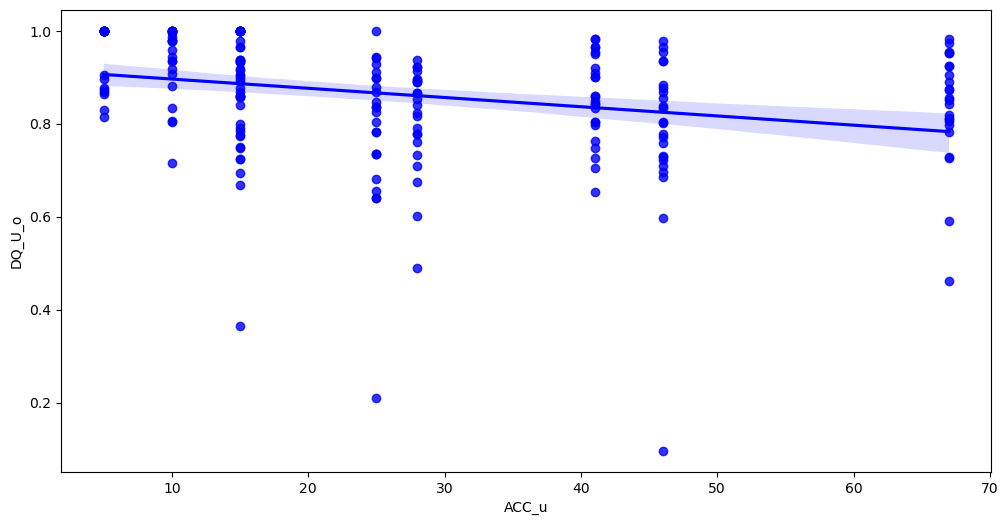

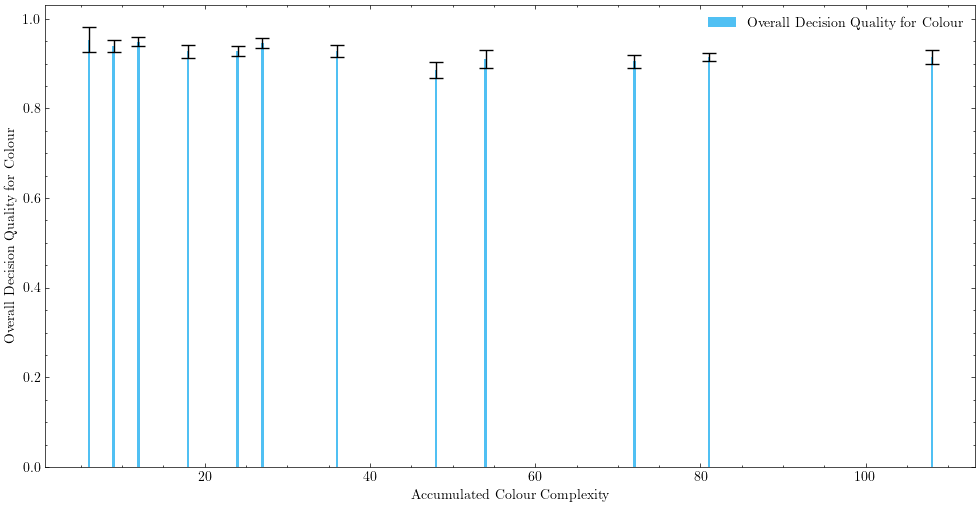

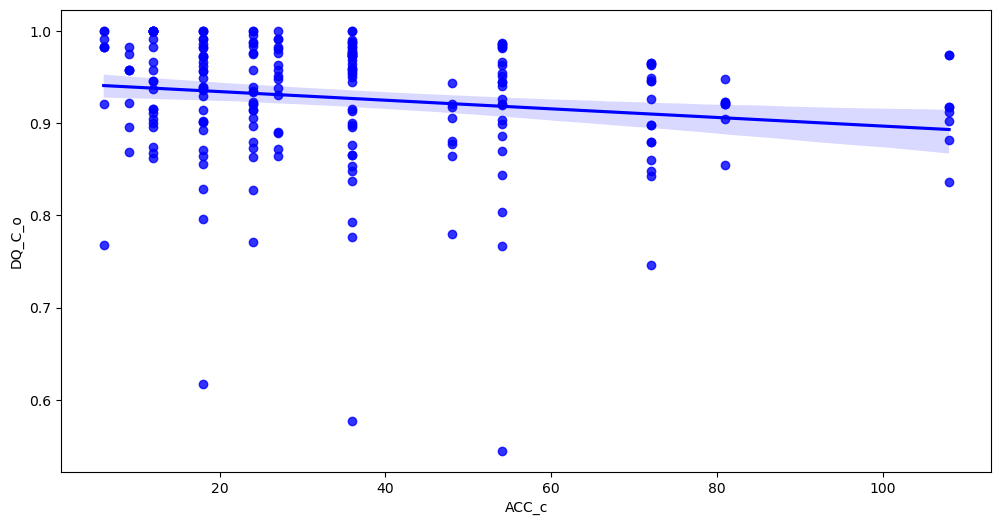

In [49]:
twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Overall Decision Quality for Urn', x_name='ACC_u', x_label='Accumulated Urn Complexity', out=False)
plt.figure(figsize=(12, 6), dpi=100)
sns.regplot(x='ACC_u', y='DQ_U_o', data=participant_data, scatter=True, color='blue')
plt.show()
twoAttributes_bar(participant_data, y_name='DQ_C_o', y_label='Overall Decision Quality for Colour', x_name='ACC_c', x_label='Accumulated Colour Complexity', out=False)
plt.figure(figsize=(12, 6), dpi=100)
sns.regplot(x='ACC_c', y='DQ_C_o', data=participant_data, scatter=True, color='blue')
plt.show()

### Response Time Vs Complexity

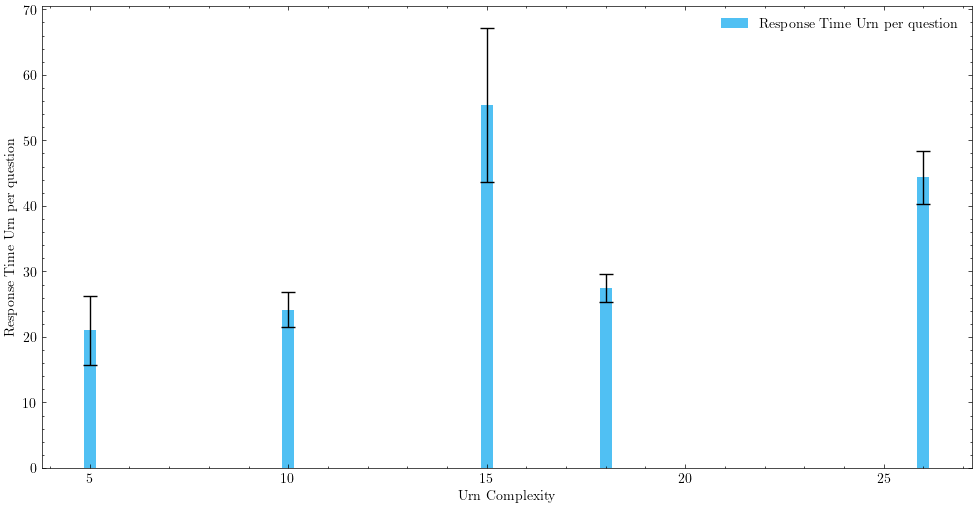

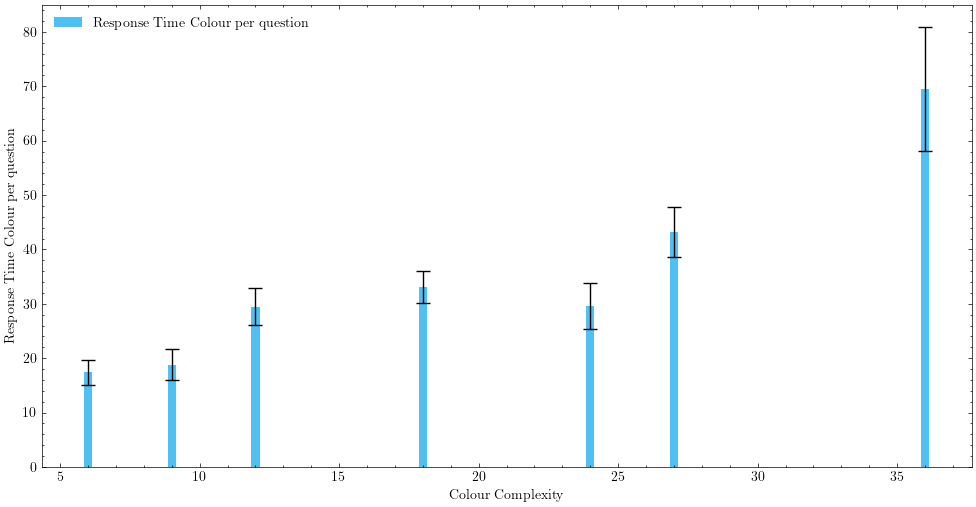

In [50]:
twoAttributes_bar(participant_data, y_name='responseTimeUrn', y_label='Response Time Urn per question', x_name='CC_u', x_label='Urn Complexity ', out=False)
twoAttributes_bar(participant_data, y_name='responseTimeColour', y_label='Response Time Colour per question', x_name='CC_c', x_label='Colour Complexity ', out=False)

## Pool Urn Decision Quality and Complexity together

In [51]:
urnColumns = ['participantID', 'instanceName', 'responseTimeUrn', 'DQ_U_o', 'CC_u']
colColumns = ['participantID', 'instanceName', 'responseTimeColour', 'DQ_C_o', 'CC_c']


urn_df = participant_data[urnColumns]
col_df = participant_data[colColumns]

urn_df['questionType'] = 'Urn'
col_df['questionType'] = 'Colour'

urnColumnNameMappings = {'responseTimeUrn': 'responseTime', 
                         'JSD_Urn': 'JSD',
                         'urn_complexity_weighted': 'complexityWeighted',
                         'urn_complexity_MD': 'complexityMD',
                         'urn_complexity_total': 'complexityTotal'}

colColumnNameMappings = {'responseTimeColour': 'responseTime',
                            'JSD_Col': 'JSD',
                            'col_complexity_weighted': 'complexityWeighted',
                            'col_complexity_MD': 'complexityMD',
                            'col_complexity_total': 'complexityTotal'}

merged_df = pd.concat([urn_df.rename(columns= urnColumnNameMappings), 
                       col_df.rename(columns= colColumnNameMappings)], 
                      ignore_index=True)



/var/folders/3k/29h810g919l7v35mx2b6pj9h0000gn/T/ipykernel_68393/1623128020.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urn_df['questionType'] = 'Urn'
/var/folders/3k/29h810g919l7v35mx2b6pj9h0000gn/T/ipykernel_68393/1623128020.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_df['questionType'] = 'Colour'


## Basic Information

In [52]:
def qualityHistogram(df, title, x_name, x_label):
    '''
    Inputs: 
    df is the input dataframe
    x_name is the column name of the data to be plotted
    x_label is the label for the x-axis
    Ouputs: 
    Histogram of the data
    '''
    with plt.style.context("science"):
        plt.figure(figsize=(10, 6), dpi=100)
        plt.hist(df[x_name], bins=10, range=(0,1), color=COLORS[1], edgecolor=COLORS[1], alpha=0.7)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel('Frequency')
        plt.xlim(0, 1)
        plt.show()



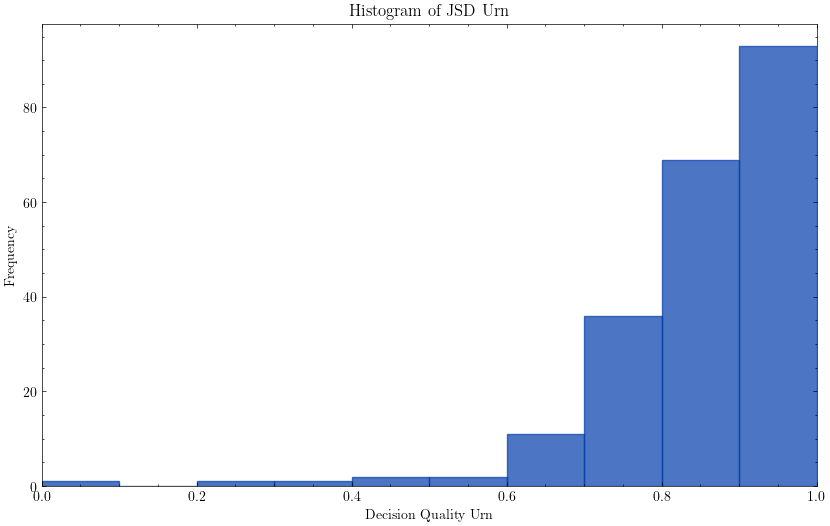

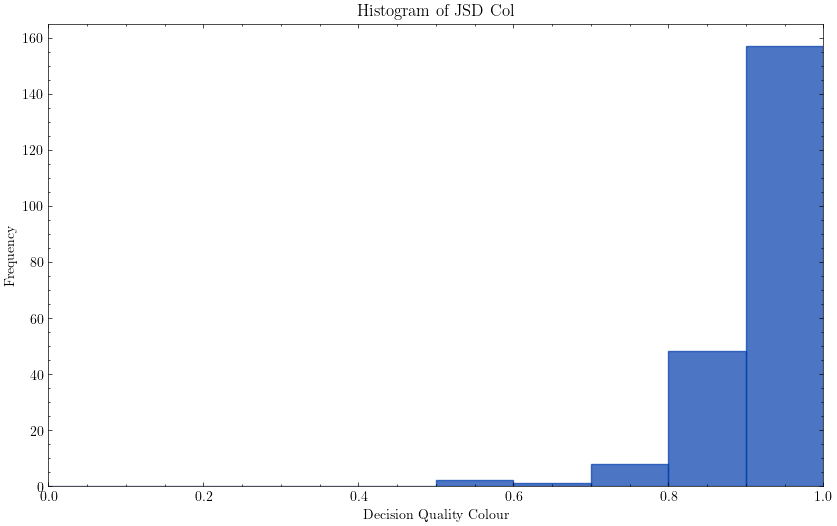

In [53]:
qualityHistogram(participant_data, 'Histogram of JSD Urn', 'DQ_U_o', 'Decision Quality Urn')
qualityHistogram(participant_data, 'Histogram of JSD Col', 'DQ_C_o', 'Decision Quality Colour')


# Regressions

## Bayesian Regressions

### H1-B In the state updating question, decision quality does not decrease as the number of potential signals (number of possible colors) in an instance increase, since more potential signals does not increase computational complexity.

In [54]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r',
       'uC_r', 'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c',
       'cP_c', 'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s',
       'cW_s', 'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD',
       'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc',
       'JSD_U_rs', 'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s',
       'EWCC_u', 'MDCC_u', 'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u',
       'ACC_c', 'AEWCC_u', 'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

### H2-C In state updating task, step-wise decision quality for the third ball draw is no lower than for the second ball draw, as the belief updating process of the third and second draws have the same computational complexity.

### H4 In signal prediction task, the step-wise decision quality for the third ball draw is no lower than for the second ball draw and the first ball draw, as the belief updating process of the third draw has the same computational complexity with for the second draw and the first ball draw.

### H1 In the question regarding the hidden state of the world (the state updating task), decision quality is predicted to be negatively correlated with computational complexity.

### H2 In state updating task, step-wise decision quality (decision quality taking into account participants previous answers as priors of the next updating) is negatively correlated with step-wise computational complexity.

In [55]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r',
       'uC_r', 'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c',
       'cP_c', 'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s',
       'cW_s', 'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD',
       'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc',
       'JSD_U_rs', 'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s',
       'EWCC_u', 'MDCC_u', 'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u',
       'ACC_c', 'AEWCC_u', 'AEWCC_c', 'AMDCC_u', 'AMDCC_c'],
      dtype='object')

In [56]:
# Define the model
model = mixedlm("JSD_Urn ~ urn_complexity_weighted", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

PatsyError: Error evaluating factor: NameError: name 'JSD_Urn' is not defined
    JSD_Urn ~ urn_complexity_weighted
    ^^^^^^^

In [ ]:
# Define the model
model = mixedlm("JSD_Urn ~ urn_complexity_weighted + responseTimeUrn", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

In [ ]:
# Define the model
model = mixedlm("JSD_Col ~ col_complexity_weighted", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

In [ ]:
# Define the model
model = mixedlm("JSD_Col ~ col_complexity_weighted + responseTimeColour", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# Other Things

In [ ]:
import time

start_time = time.time()
for i in range(100000000):
    result = 0.25 * 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")

In [ ]:
import time

start_time = time.time()
result = 0
for i in range(100000000):
    result = 0.25 + 0.33
end_time = time.time()

time_consumed = end_time - start_time
print(f"Time consumed for calculating: {time_consumed} seconds")